<a href="https://colab.research.google.com/github/namakutiwik/New-York-CitiBike/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data  trips_cleaned.csv


# Import Library & Dataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import *
import seaborn as sns
from matplotlib import rcParams
import datetime as dt
%matplotlib inline
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12,8)

In [4]:
# Stations dataset
stations = pd.read_csv('/content/drive/My Drive/Kemenkes - Data Analyst/stations.csv')
stations.head(2)

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,last_reported,Record Count
0,457,Broadway & W 58 St,6948.10,40.766953,-73.981693,71.0,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,"Jan 1, 1970, 12:00:00 AM",1
1,533,Broadway & W 38 St,6441.05,40.752996,-73.987216,71.0,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,"Jan 1, 1970, 12:00:00 AM",1


In [5]:
# Trips dataset
trip = pd.read_csv('/content/drive/My Drive/Kemenkes - Data Analyst/trips.csv')
trip = trip.drop_duplicates()
trips = trip.iloc[1: , :]
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,Record Count
1,208.0,"Feb 19, 2015, 5:07:00 PM","Feb 19, 2015, 5:11:00 PM",351.0,Front St & Maiden Ln,40.705310,-74.006126,259.0,South St & Whitehall St,40.701221,-74.012342,15555.0,Subscriber,1979.0,male,NaN,2
2,919.0,"Apr 18, 2018, 4:34:02 PM","Apr 18, 2018, 4:49:22 PM",441.0,E 52 St & 2 Ave,40.756014,-73.967416,297.0,E 15 St & 3 Ave,40.734232,-73.986923,32696.0,Subscriber,1950.0,male,NaN,1


# Exploratory Data Analysis



*  Top 5 stations with the most starts (showing # of starts)
* Trip duration by user type
* Most popular trips based on start station and stop station)
* Rider behaviour by Gender and Age based on avg trip distance (station to station), median speed (trip duration / distance traveled)
* What is the busiest bike in NYC? How many times was it used? How many minutes was it in use?





Information of trip dataset:
1. Trip Duration (seconds) — How long a trip lasted
2. Start Time and Date - Self explanatory
3. Stop Time and Date - Self explanatory
4. Start Station Name - Self explanatory
5. End Station Name - Self explanatory
6. Station ID - Unique identifier for each station
7. Station Lat/Long - Coordinates
8. Bike ID - unique identifier for each bike
9. User Type (Customer = 24-hour pass or 3-day pass user;  Subscriber = Annual Member) - Customers are usually tourists, subscribers are usually NYC residents
10. Gender (Zero=unknown; 1=male; 2=female) - Usually unknown for customers since they often sign up at a kiosk
11. Year of Birth - Self entered, not validated by an ID.



## Cleaning Trips Dataset

In [6]:
trips.head(2)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,Record Count
1,208.0,"Feb 19, 2015, 5:07:00 PM","Feb 19, 2015, 5:11:00 PM",351.0,Front St & Maiden Ln,40.705310,-74.006126,259.0,South St & Whitehall St,40.701221,-74.012342,15555.0,Subscriber,1979.0,male,NaN,2
2,919.0,"Apr 18, 2018, 4:34:02 PM","Apr 18, 2018, 4:49:22 PM",441.0,E 52 St & 2 Ave,40.756014,-73.967416,297.0,E 15 St & 3 Ave,40.734232,-73.986923,32696.0,Subscriber,1950.0,male,NaN,1


In [7]:
# Extract year from startime to get the trips' year
trips['trips_year'] = pd.DatetimeIndex(trips['starttime']).year
# trips['month_year'] = pd.to_datetime(trips['starttime']).dt.to_period('M') #to get per month-year
trips.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan,Record Count,trips_year
1,208.0,"Feb 19, 2015, 5:07:00 PM","Feb 19, 2015, 5:11:00 PM",351.0,Front St & Maiden Ln,40.705310,-74.006126,259.0,South St & Whitehall St,40.701221,-74.012342,15555.0,Subscriber,1979.0,male,NaN,2,2015
2,919.0,"Apr 18, 2018, 4:34:02 PM","Apr 18, 2018, 4:49:22 PM",441.0,E 52 St & 2 Ave,40.756014,-73.967416,297.0,E 15 St & 3 Ave,40.734232,-73.986923,32696.0,Subscriber,1950.0,male,NaN,1,2018
3,1922.0,"Oct 3, 2013, 4:09:26 PM","Oct 3, 2013, 4:41:28 PM",358.0,Christopher St & Greenwich St,40.732916,-74.007114,457.0,Broadway & W 58 St,40.766953,-73.981693,15476.0,Subscriber,1947.0,male,NaN,1,2013


In [8]:
pd.unique(trips.trips_year)

array([2015, 2018, 2013, 2017, 2016, 2014])

In [9]:
# Get only dataset 2015-2017
# Get indexes where name column doesn't have value
indexNames = trips[~(trips['trips_year'] == 2015) & ~(trips['trips_year'] == 2016) & ~(trips['trips_year'] == 2017)].index 
# Delete these row indexes from dataFrame
trips.drop(indexNames , inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# remove unnecessary columns
trips.drop(trips.columns[[15, 16]], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Adjusting Station ID vs Station Name

**Checking the imbalance**

In [11]:
print(len(unique(trips.start_station_id)))
print(len(unique(trips.end_station_id)))

827
833


In [12]:
print(len(unique(trips.start_station_name)))
print(len(unique(trips.end_station_name)))

841
849


In [13]:
id_name_s = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_s = id_name_s.groupby("start_station_id")
id_name_s = id_name_s.agg({"start_station_name": "nunique"})
id_name_s = id_name_s.reset_index()
len(id_name_s[id_name_s['start_station_name']>=2])

25

In [14]:
id_name_e = trips[['start_station_id','start_station_name','end_station_id', 'end_station_name']]
id_name_e = id_name_e.groupby("end_station_id")
id_name_e = id_name_e.agg({"end_station_name": "nunique"})
id_name_e = id_name_e.reset_index()
len(id_name_e[id_name_e['end_station_name']>=2])

25

In [15]:
id_name_e[id_name_e['end_station_name']>=2].head()

,end_station_id,end_station_name
37,233.0,2
43,242.0,2
50,250.0,2
101,312.0,2
118,329.0,2


In [16]:
a = trips[trips['end_station_id']==329.0]
unique(a.end_station_name)

array(['Greenwich St & N Moore St', 'Greenwich St & North Moore St'],
      dtype=object)

Since the difference, it should use id rather than name

**Create dataframe as dictionary**

In [17]:
start = trips[['start_station_id', 'start_station_name']]
len(unique(start.start_station_id))

827

In [18]:
start.drop_duplicates(subset='start_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
start.rename(columns = {'start_station_id':'station_id','start_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
end = trips[['end_station_id', 'end_station_name']]
len(unique(end.end_station_id))

833

In [21]:
end.drop_duplicates(subset='end_station_id', keep="first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
end.rename(columns = {'end_station_id':'station_id','end_station_name':'station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [23]:
id_name = pd.concat([start,end])
id_name.drop_duplicates(subset='station_id', keep="first", inplace=True)

In [24]:
id_name['station_id'] = id_name['station_id'].astype(int)

In [25]:
id_name.head(3)

,station_id,station_name
1,351,Front St & Maiden Ln
5,334,W 20 St & 7 Ave
6,500,Broadway & W 51 St


In [26]:
len(id_name)

839

**Combine the dataframe using lookup func.**

In [27]:
trips['start_station_id_copy'] = trips['start_station_id']
trips['end_station_id_copy'] = trips['end_station_id']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
trips.start_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)
trips.end_station_id_copy.replace(dict(zip(id_name.station_id, id_name.station_name)), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [29]:
trips.drop(['start_station_name','end_station_name'], 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
trips.rename(columns = {'start_station_id_copy':'start_station_name','end_station_id_copy':'end_station_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
trips.head(3)

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,trips_year,start_station_name,end_station_name
1,208.0,"Feb 19, 2015, 5:07:00 PM","Feb 19, 2015, 5:11:00 PM",351.0,40.705310,-74.006126,259.0,40.701221,-74.012342,15555.0,Subscriber,1979.0,male,2015,Front St & Maiden Ln,South St & Whitehall St
5,832.0,"May 27, 2017, 10:33:25 AM","May 27, 2017, 10:47:18 AM",334.0,40.742388,-73.997262,3435.0,40.718822,-73.995960,20978.0,Subscriber,1998.0,male,2017,W 20 St & 7 Ave,Grand St & Elizabeth St
6,689.0,"Aug 31, 2017, 8:14:53 PM","Aug 31, 2017, 8:26:22 PM",500.0,40.762288,-73.983362,3175.0,40.777480,-73.982886,27724.0,Subscriber,1945.0,male,2017,Broadway & W 51 St,W 70 St & Amsterdam Ave


### Any missing value?

In [32]:
#Percentage of missing data.
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
missing_data(trips)

,Total,Percent
end_station_name,0,0.0
start_station_name,0,0.0
trips_year,0,0.0
gender,0,0.0
birth_year,0,0.0
usertype,0,0.0
bikeid,0,0.0
end_station_longitude,0,0.0
end_station_latitude,0,0.0
end_station_id,0,0.0


### Data description

In [33]:
trips.dtypes

tripduration               float64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                     float64
usertype                    object
birth_year                 float64
gender                      object
trips_year                   int64
start_station_name          object
end_station_name            object
dtype: object

In [34]:
#Ensure data is formatted correctly to avoid errors in the visuals
trips['starttime'] = to_datetime(trips['starttime'])
trips['stoptime'] = to_datetime(trips['stoptime'])
trips['start_station_id'] = trips['start_station_id'].astype('category')
trips['end_station_id'] = trips['end_station_id'].astype('category')
trips['bikeid'] = trips['bikeid'].astype('category')
trips['birth_year'] = trips['birth_year'].astype('category')
trips['trips_year'] = trips['trips_year'].astype('category')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [35]:
round(trips.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
count,489699.00,489699.00,489699.00,489699.00,489699.00
mean,894.41,40.74,-73.99,40.74,-73.99
std,8749.22,0.03,0.02,0.06,0.11
min,60.00,40.45,-74.03,0.00,-74.04
25%,359.00,40.72,-74.00,40.72,-74.00
50%,599.00,40.73,-73.99,40.73,-73.99
75%,1005.00,40.75,-73.98,40.75,-73.98
max,4245425.00,40.81,-73.91,40.81,0.00


### Avoid broken bike using filter

* Citi Bike riders often come across broken bikes. Let’s drop any trips where a trip lasted less than 90 seconds and the start station == end station. 90 seconds is an arbitrary choice based on how long it would take a rider to realize a bike isn’t working properly and coming back to the station to return it and take a new on. 
* Another measure which can be used is 372 seconds (25% quartile). This is based on the assumption that if someone is making a round trip, it most likely is to perform some quick task which is not close enough to walk to, thus this trip should be at least a little bit longer than the shortest trip. In case it was a short trip, let’s add the extra and condition to make sure the start and end station names are the same.

In [36]:
#Clear up enviornment and drop double count
trips = trips.drop(trips.index[(trips['tripduration'] < 90) & 
                  (trips['start_station_name'] == trips['end_station_name'])])

### Theft bike using filter

The first 45 minutes of each ride is included for Annual Members, and the first 30 minutes of each ride is included for Day Pass users. If you want to keep a bike out for longer, it’s only an extra $4 for each additional 15 minutes.

It's safe to assume, no one (or very few people) will be willing to rent a bike for more than 2 hours, especially a clunky citibike. If they did, it would cost them an additional $20 assuming they're annual subscribers. It would be more economical for them to buy a bike if they want that workout or use one of the tour bikes in central park if they want to tour and explore the city on a bike.  

In [37]:
#Remove anomalies based on definition above
trips = trips.drop(trips.index[(trips['tripduration'] > 7200)])

### Export dataset

In [38]:
trips.to_csv (r'trips_cleaned.csv', index = False, header=True)

## Part 1: Top 5 Start Stations

In [39]:
#Data for Top 5 Stations
#top5 = trips.groupby('trips_year')['start_station_name'].value_counts().groupby('trips_year').head(5).reset_index(name='number_of_start')
top5 = trips.groupby('trips_year')['start_station_name'].value_counts().reset_index(name='number_of_start').groupby(['start_station_name']).mean()
top5 = pd.DataFrame(top5.to_records()).sort_values(by=['number_of_start'],ascending=False).head(5)
top5

,start_station_name,number_of_start
458,Grand St & Elizabeth St,1543.000000
693,University Pl & E 8 St,1425.500000
532,Lexington Ave & E 24 St,1388.000000
309,E 12 St & 3 Ave,1113.666667
660,South End Ave & Liberty St,1103.000000


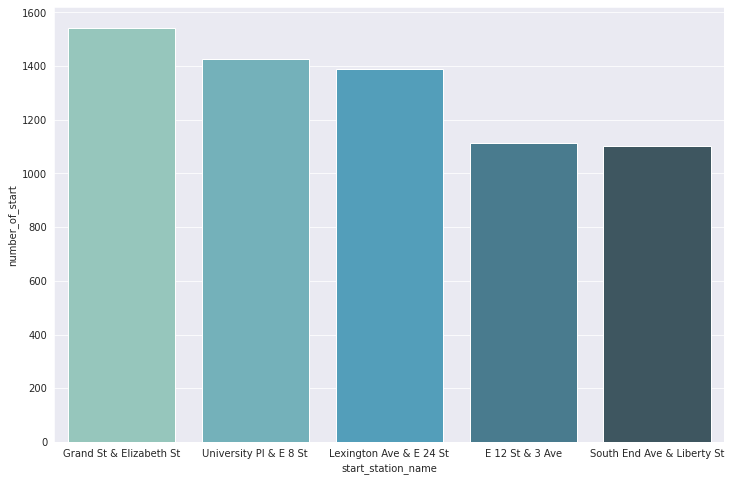

In [40]:
#Barplot
ax1 = sns.barplot(x='start_station_name', y='number_of_start', data = top5, palette="GnBu_d"), #hue='trips_year'
plt.show()

**Next Steps and Business Use Case:**

---
* Would be interesting to visualize these stations on a map to see how close they are to each other. This could be used to determine which areas require additional stations or bikes.
* Lexington Ave & E 24 St is the most favorite along the period

## Part 2: Trip Duration by User Type

In [41]:
#pd.unique(trips.usertype)
a = trips.loc[trips['trips_year'] == 2015]
pd.unique(a.usertype)

array(['Subscriber'], dtype=object)

In [42]:
#Data for Top 5 Stations visual
TD_user = round(trips.groupby(['trips_year','usertype'])['tripduration'].mean().reset_index(name='avg_tripduration'),2)
TD_user = TD_user.dropna(subset=['avg_tripduration'])
TD_user = pd.DataFrame(TD_user.to_records())
TD_user

,index,trips_year,usertype,avg_tripduration
0,1,2015,Subscriber,765.16
1,2,2016,Customer,1296.92
2,3,2016,Subscriber,770.30
3,4,2017,Customer,1326.48
4,5,2017,Subscriber,751.53


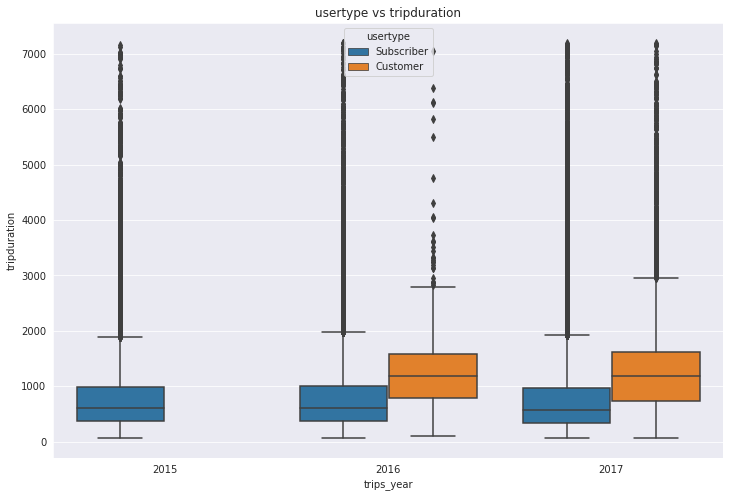

In [43]:
sns.boxplot(x='trips_year', y='tripduration', hue='usertype', data=trips, showfliers=True)
plt.title("usertype vs tripduration", fontsize= 12)
plt.show()

**Next Steps & Business Use Case:**
*   Customers are allowed 30 min per bike while subscribers are allowed 45 minutes per bike. 
* Data clearly indicates that customers tend to use bikes longer. If the main concern is to have bikes available at docks, then the current time limit makes sense. However, if Citi Bike would like to be user-centric, giving customers more time per bike is worth exploring.

## Part 3: Most Popular Trip

In [44]:
#Identify the 10 most popular trips
route = pd.DataFrame()
route = trips.groupby(['trips_year','start_station_name','end_station_name']).size().reset_index(name = 'number_of_trips')
route["trip"] = route["start_station_name"] + " to " + route["end_station_name"]
route = route.drop(['start_station_name', "end_station_name"], axis = 1)
route = route.groupby(['trip'])['number_of_trips'].mean().reset_index(name = 'number_of_trips')
route = route.sort_values('number_of_trips', ascending = False).head(10)
route

,trip,number_of_trips
442010,Lispenard St & Broadway to Norfolk St & Broome St,154.333333
569954,University Pl & E 8 St to E 12 St & 3 Ave,142.333333
254695,E 12 St & 3 Ave to University Pl & E 8 St,129.333333
354946,Franklin St & W Broadway to South End Ave & Li...,116.666667
275903,E 33 St & 2 Ave to Lexington Ave & E 24 St,113.000000
437638,Lexington Ave & E 24 St to E 33 St & 2 Ave,108.000000
394334,Henry St & Grand St to Norfolk St & Broome St,107.666667
156946,Broadway & W 53 St to W 52 St & 11 Ave,105.000000
542951,South End Ave & Liberty St to Franklin St & W ...,103.666667
549653,St Marks Pl & 2 Ave to Mercer St & Bleecker St,101.333333


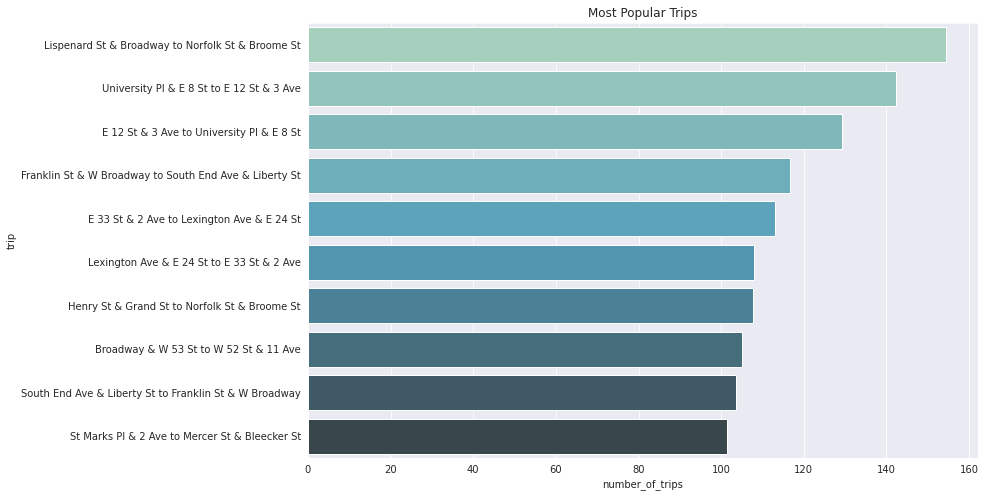

In [45]:
#Barplot
ax2 = sns.barplot(x='number_of_trips', y='trip', data = route, palette="GnBu_d") #hue='trips_year'
ax2.set_title('Most Popular Trips', fontsize = 12)
plt.show()

**Next Steps & Business Use Case:**
* Would be interesting to see this on a map to see if riders are traveling from North to South, East to West, etc. 
* Additionally, it would be good to see most popular trips based on the time of day. This can help Citi Bike determine where to keep bikes and where to have docks available based on the time of day. The assumption being riders travel in one direction to work in the morning and in the opposite direction to get home in the evening.

## Part 4: Rider Behaviour by Gender and Age

In [46]:
behav = trips[["tripduration", "start_station_latitude", "start_station_longitude", "end_station_latitude", "end_station_longitude", "birth_year", "gender", "trips_year"]]
behav['age'] = 2017 - trips['birth_year'].astype(int)
behav.head(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age
1,208.0,40.705310,-74.006126,40.701221,-74.012342,1979.0,male,2015,38
5,832.0,40.742388,-73.997262,40.718822,-73.995960,1998.0,male,2017,19


In [47]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

In [48]:
dist = []
for ind in trips.index:
    jarak = round(haversine(behav['start_station_latitude'][ind], behav['start_station_longitude'][ind],
                      behav['end_station_latitude'][ind], behav['end_station_longitude'][ind]),2)
    dist.append((jarak))
cols=['jarak']

result = pd.DataFrame(dist, columns=cols)

In [49]:
behav['distance'] = dist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [50]:
#drop circular round trips
behav = behav.drop(behav.index[(behav['distance'] == 0)])

In [51]:
pd.unique(behav.gender)

array(['male', 'female', 'unknown'], dtype=object)

In [52]:
len(behav[behav['gender'] == 'unknown'])

3734

In [53]:
len(behav)

476055

In [54]:
behav = behav.drop(behav.index[(behav['gender'] == 'unknown')])

In [55]:
len(behav.index[(behav['age'] >= 100)])

5639

In [56]:
behav['mile_per_hour'] = round(behav['distance']/(behav['tripduration']/3600),2)

In [57]:
round(behav.describe(),2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,age,distance,mile_per_hour
count,472321.00,472321.00,472321.00,472321.00,472321.00,472321.00,472321.00,472321.00
mean,756.89,40.74,-73.99,40.74,-73.99,48.45,1.03,5.28
std,579.50,0.03,0.02,0.03,0.02,25.77,0.79,1.86
min,61.00,40.45,-74.03,40.65,-74.04,16.00,0.02,0.04
25%,358.00,40.72,-74.00,40.72,-74.00,23.00,0.48,4.14
50%,592.00,40.73,-73.99,40.73,-73.99,67.00,0.80,5.26
75%,984.00,40.75,-73.98,40.75,-73.98,70.00,1.33,6.44
max,7192.00,40.81,-73.91,40.81,-73.91,143.00,20.15,162.00


In [58]:
behav.groupby(['age','gender']).median()['mile_per_hour'].unstack().isnull().sum()

gender
female    19
male       5
dtype: int64

In [59]:
bin = np.linspace(min(behav['age']), max(behav['age']), 15)
len(bin)

15

In [60]:
cat = pd.Series(np.arange(1,len(bin)+1,1))
len(cat)

15

In [61]:
bin = pd.DataFrame(bin)
bin = bin.rename(columns = {0:'bin'})
cat = pd.DataFrame(cat)
cat = cat.rename(columns = {0:'cat'})
age_bin = pd.concat([bin, cat], axis=1)
age_bin['bin2'] = age_bin.bin.shift(1)
age_bin['bin2'] = age_bin['bin2'].replace(np.nan, 0)
age_bin['cat2'] = round(age_bin['bin2'],2).astype(str) + '-' + round(age_bin['bin'],2).astype(str)
age_bin.head()

,bin,cat,bin2,cat2
0,16.000000,1,0.000000,0.0-16.0
1,25.071429,2,16.000000,16.0-25.07
2,34.142857,3,25.071429,25.07-34.14
3,43.214286,4,34.142857,34.14-43.21
4,52.285714,5,43.214286,43.21-52.29


In [62]:
def f(behav):
    if behav['age'] > age_bin.iloc[0,2] and behav['age'] <= age_bin.iloc[0,0]:
        val = age_bin.iloc[0,1] 
    elif behav['age'] > age_bin.iloc[1,2] and behav['age'] <= age_bin.iloc[1,0]:
        val = age_bin.iloc[1,1]
    elif behav['age'] > age_bin.iloc[2,2] and behav['age'] <= age_bin.iloc[2,0]:
        val = age_bin.iloc[2,1]
    elif behav['age'] > age_bin.iloc[3,2] and behav['age'] <= age_bin.iloc[3,0]:
        val = age_bin.iloc[3,1]
    elif behav['age'] > age_bin.iloc[4,2] and behav['age'] <= age_bin.iloc[4,0]:
        val = age_bin.iloc[4,1]
    elif behav['age'] > age_bin.iloc[5,2] and behav['age'] <= age_bin.iloc[5,0]:
        val = age_bin.iloc[5,1]
    elif behav['age'] > age_bin.iloc[6,2] and behav['age'] <= age_bin.iloc[6,0]:
        val = age_bin.iloc[6,1]
    elif behav['age'] > age_bin.iloc[7,2] and behav['age'] <= age_bin.iloc[7,0]:
        val = age_bin.iloc[7,1]
    elif behav['age'] > age_bin.iloc[8,2] and behav['age'] <= age_bin.iloc[8,0]:
        val = age_bin.iloc[8,1]
    elif behav['age'] > age_bin.iloc[9,2] and behav['age'] <= age_bin.iloc[9,0]:
        val = age_bin.iloc[9,1]
    elif behav['age'] > age_bin.iloc[10,2] and behav['age'] <= age_bin.iloc[10,0]:
        val = age_bin.iloc[10,1]
    elif behav['age'] > age_bin.iloc[11,2] and behav['age'] <= age_bin.iloc[11,0]:
        val = age_bin.iloc[11,1]
    elif behav['age'] > age_bin.iloc[12,2] and behav['age'] <= age_bin.iloc[12,0]:
        val = age_bin.iloc[12,1]
    elif behav['age'] > age_bin.iloc[13,2] and behav['age'] <= age_bin.iloc[13,0]:
        val = age_bin.iloc[13,1]
    else:
        val = age_bin.iloc[14,1]
    return val

#create new column 'Good' using the function above
behav['age_cat'] = behav.apply(f, axis=1)

In [63]:
behav.head(2)

,tripduration,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,birth_year,gender,trips_year,age,distance,mile_per_hour,age_cat
1,208.0,40.705310,-74.006126,40.701221,-74.012342,1979.0,male,2015,38,0.43,7.44,4
5,832.0,40.742388,-73.997262,40.718822,-73.995960,1998.0,male,2017,19,1.63,7.05,2


In [64]:
behav_2015 = behav[behav.trips_year == 2015]
speed_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2015.dropna(inplace=True)

In [65]:
speed_age_gender_2015 = pd.merge(age_bin, speed_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2015 = speed_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [66]:
behav_2015 = behav[behav.trips_year == 2015]
distance_age_gender_2015 = behav_2015.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2015.dropna(inplace=True)

In [67]:
distance_age_gender_2015 = pd.merge(age_bin, distance_age_gender_2015, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2015 = distance_age_gender_2015.drop(['bin','cat','bin2'], axis = 1)

In [68]:
behav_2016 = behav[behav.trips_year == 2016]
speed_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2016.dropna(inplace=True)

In [69]:
speed_age_gender_2016 = pd.merge(age_bin, speed_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2016 = speed_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [70]:
behav_2016 = behav[behav.trips_year == 2016]
distance_age_gender_2016 = behav_2016.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2016.dropna(inplace=True)

In [71]:
distance_age_gender_2016 = pd.merge(age_bin, distance_age_gender_2016, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2016 = distance_age_gender_2016.drop(['bin','cat','bin2'], axis = 1)

In [72]:
behav_2017 = behav[behav.trips_year == 2017]
speed_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['mile_per_hour'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
speed_age_gender_2017.dropna(inplace=True)

In [73]:
speed_age_gender_2017 = pd.merge(age_bin, speed_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
speed_age_gender_2017 = speed_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [74]:
behav_2017 = behav[behav.trips_year == 2017]
distance_age_gender_2017 = behav_2017.groupby(['trips_year','age_cat','gender']).median()['distance'].unstack().sort_values(['trips_year','age_cat'], ascending=True)
distance_age_gender_2017.dropna(inplace=True)

In [75]:
distance_age_gender_2017 = pd.merge(age_bin, distance_age_gender_2017, left_on = 'cat', right_on = 'age_cat', how='right')
distance_age_gender_2017 = distance_age_gender_2017.drop(['bin','cat','bin2'], axis = 1)

In [76]:
speed_age_gender = pd.concat([speed_age_gender_2015, speed_age_gender_2016, speed_age_gender_2017], axis=0)
speed_age_gender = speed_age_gender.groupby(['cat2']).mean()
speed_age_gender = pd.merge(speed_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
speed_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

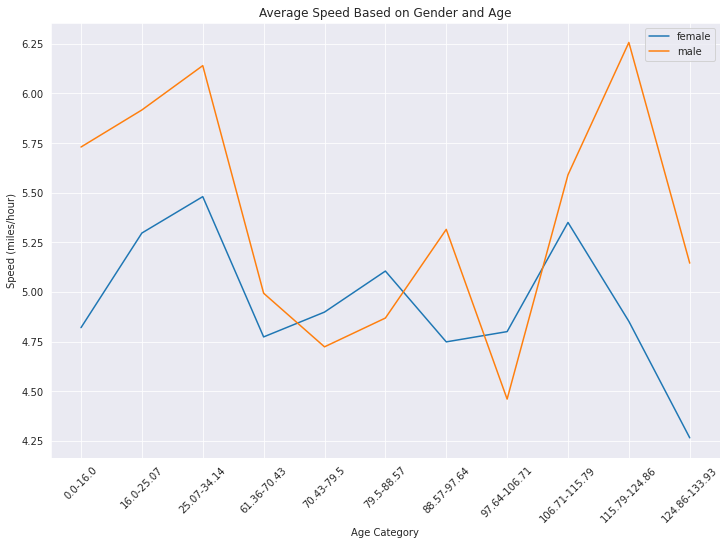

In [77]:
#Barplot
plt.plot(speed_age_gender.cat2, speed_age_gender.female, label = "female")
plt.plot(speed_age_gender.cat2, speed_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Speed (miles/hour)')
plt.title('Average Speed Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

In [78]:
distance_age_gender = pd.concat([distance_age_gender_2015, distance_age_gender_2016, distance_age_gender_2017], axis=0)
distance_age_gender = distance_age_gender.groupby(['cat2']).mean()
distance_age_gender = pd.merge(distance_age_gender, age_bin, left_on='cat2', right_on='cat2', how='left').sort_values(by='cat')
distance_age_gender.drop(['bin', 'cat', 'bin2'], axis=1, inplace=True)

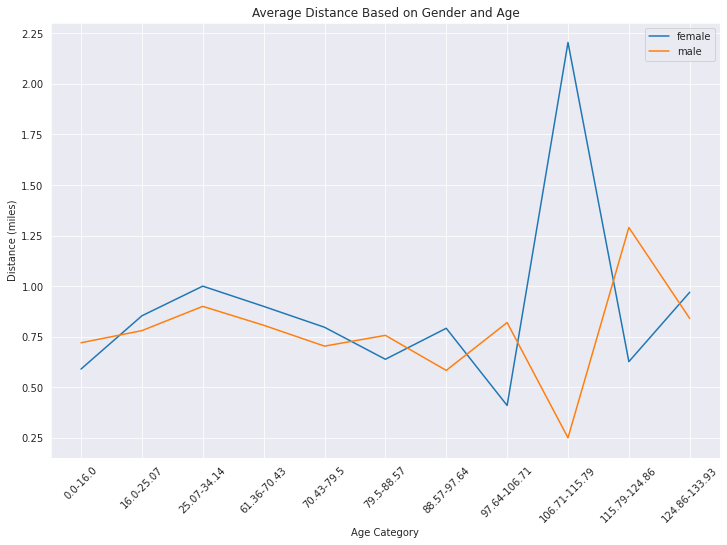

In [79]:
#Barplot
plt.plot(distance_age_gender.cat2, distance_age_gender.female, label = "female")
plt.plot(distance_age_gender.cat2, distance_age_gender.male, label = "male")
plt.legend()
plt.xlabel('Age Category')
plt.ylabel('Distance (miles)')
plt.title('Average Distance Based on Gender and Age')
plt.xticks(rotation=45)
plt.show()

## Part 5: Busiest Bike by Times and Minutes Used

In [80]:
#Bike usage based on number of times used
bike_use = pd.DataFrame()
bike_use = trips.groupby(['trips_year','bikeid']).size().reset_index(name = 'times_used')
bike_use = bike_use.sort_values('times_used', ascending = False)
bike_use['bikeid'] = bike_use['bikeid'].astype(int).astype(str)
bike_use['bikeid'] = ('Bike ' + bike_use['bikeid'])
bike_use = bike_use.groupby('bikeid').mean()['times_used'].reset_index(name = 'times_used').sort_values(by=['times_used'], ascending=False).head(10)
bike_use.head()

,bikeid,times_used
1820,Bike 16682,26.000000
5689,Bike 21273,25.333333
3777,Bike 18934,25.333333
3845,Bike 19014,25.333333
3504,Bike 18623,25.333333


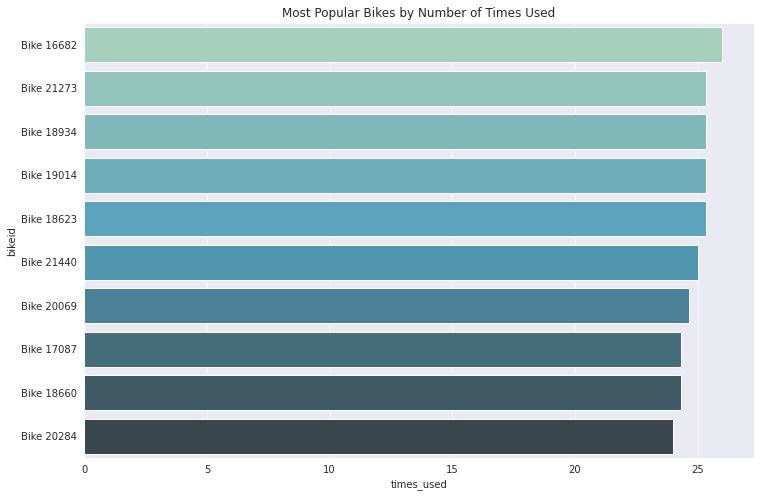

In [81]:
#Barplot
ax2 = sns.barplot(x='times_used', y='bikeid', data = bike_use, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Number of Times Used', fontsize = 12)
plt.show()

In [82]:
#Bike usage based on minutes used
bike_min = pd.DataFrame()
bike_min['sec_used'] = trips.groupby(['trips_year','bikeid'])['tripduration'].sum()
bike_min['min_used'] = round(bike_min['sec_used']/60,2)
bike_min = bike_min.sort_values('min_used', ascending = False).reset_index()
bike_min['bikeid'] = bike_min['bikeid'].astype(int).astype(str)
bike_min['bikeid'] = ('Bike ' + bike_min['bikeid'])
bike_min.drop(['sec_used'], axis = 1, inplace=True)
bike_min = bike_min.groupby('bikeid').mean()['min_used'].reset_index(name = 'min_used').sort_values(by=['min_used'], ascending=False).head(10)
bike_min.head()

,bikeid,min_used
12558,Bike 29015,760.32
11051,Bike 27500,746.97
11124,Bike 27574,694.40
11724,Bike 28175,680.58
12134,Bike 28589,648.42


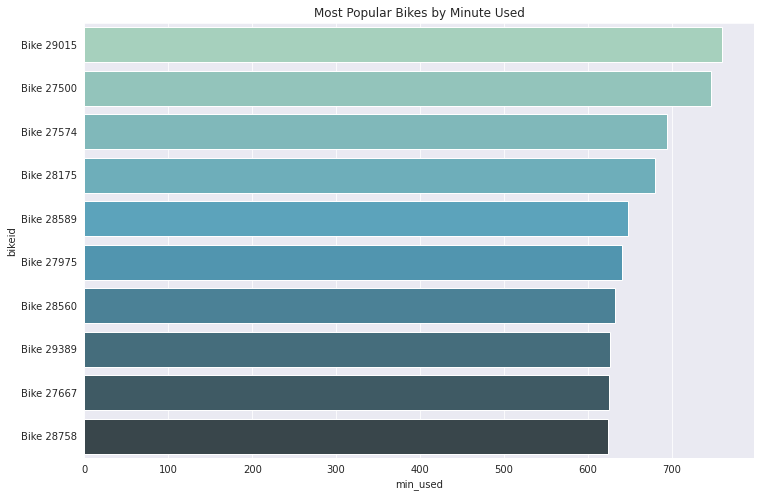

In [83]:
#Barplot
ax2 = sns.barplot(x='min_used', y='bikeid', data = bike_min, palette="GnBu_d")
ax2.set_title('Most Popular Bikes by Minute Used', fontsize = 12)
plt.show()

## Part 6: Distribution Issue

### Rebalancing

In [84]:
# Note that the end station id for one ride is the start station id for the next.
bike_journey = trips.sort_values(by=['bikeid','starttime'])

In [85]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'), 'start_station_name':0,\
                       'stoptime': pd.to_datetime('2010-09-01'),'end_station_name':0,'bikeid':0},index=[0])

In [86]:
bike_journey1 = pd.concat([offset,bike_journey]).reset_index(drop=True)
bike_journey2 = pd.concat([bike_journey,offset]).reset_index(drop=True)

In [87]:
# if end_station_id != start_station_id -> rebalancing 
# Now each row shows the end of one trip and the start of the next.
# This is the time the bike spends at the station between rides.
bike_journey = pd.concat ([bike_journey1[['bikeid','stoptime','end_station_name']]\
                   ,bike_journey2[['bikeid','starttime','start_station_name']] ],\
                    axis=1 )
bike_journey.head()

,bikeid,stoptime,end_station_name,bikeid,starttime,start_station_name
0,0.0,2010-09-01 00:00:00,0,14529.0,2015-01-14 18:42:00,Lexington Ave & E 29 St
1,14529.0,2015-01-14 18:49:00,E 39 St & 3 Ave,14529.0,2015-03-30 16:34:00,Maiden Ln & Pearl St
2,14529.0,2015-03-30 17:01:00,1 Ave & E 15 St,14529.0,2015-05-10 11:44:09,Carlton Ave & Park Ave
3,14529.0,2015-05-10 12:06:31,Clinton St & Joralemon St,14529.0,2015-05-18 15:01:49,W 14 St & The High Line
4,14529.0,2015-05-18 15:20:20,Bus Slip & State St,14529.0,2015-05-22 10:39:22,E 60 St & York Ave


In [88]:
bike_journey.columns = ['bikeid1','starttime','start_station_name','bikeid2','stoptime','end_station_name']

In [89]:
bike_journey_rebal = bike_journey[['starttime','start_station_name','stoptime','end_station_name']].\
      loc[(bike_journey.bikeid1==bike_journey.bikeid2) & (bike_journey['start_station_name'] != bike_journey['end_station_name'])]
bike_journey_rebal.reset_index(drop=True, inplace=True)
bike_journey_rebal.head()

,starttime,start_station_name,stoptime,end_station_name
0,2015-01-14 18:49:00,E 39 St & 3 Ave,2015-03-30 16:34:00,Maiden Ln & Pearl St
1,2015-03-30 17:01:00,1 Ave & E 15 St,2015-05-10 11:44:09,Carlton Ave & Park Ave
2,2015-05-10 12:06:31,Clinton St & Joralemon St,2015-05-18 15:01:49,W 14 St & The High Line
3,2015-05-18 15:20:20,Bus Slip & State St,2015-05-22 10:39:22,E 60 St & York Ave
4,2015-05-22 11:02:38,E 40 St & 5 Ave,2015-06-25 23:19:00,E 2 St & 2 Ave


### Station Flow

In [90]:
bjs=bike_journey_rebal[['starttime','start_station_name']].assign(in_out=-1) # act as -1 to indicate a bike pick-up
bje=bike_journey_rebal[['starttime','end_station_name']].assign(in_out=1) # act as 1 to indicate a drop off

In [91]:
bjs.columns=['docktime','station_name','in_out']
bje.columns=['docktime','station_name','in_out']
bjse=pd.concat([bjs,bje]).sort_values(by=['station_name','docktime']).reset_index(drop=True)

In [92]:
bjse.head()

,docktime,station_name,in_out
0,2017-08-30 14:10:20,1 Ave & E 110 St,1
1,2017-09-02 20:57:19,1 Ave & E 110 St,1
2,2017-09-03 14:31:23,1 Ave & E 110 St,1
3,2017-09-07 18:21:17,1 Ave & E 110 St,1
4,2017-09-21 14:21:14,1 Ave & E 110 St,1


**Check the station table according its availability**

In [93]:
id_name.head(3)

,station_id,station_name
1,351,Front St & Maiden Ln
5,334,W 20 St & 7 Ave
6,500,Broadway & W 51 St


In [94]:
# getting bjse with its information
dummy = pd.merge(bjse, id_name, how='inner', left_on='station_name', right_on='station_name')
bjse_info = pd.merge(dummy, stations[['station_id','capacity','num_bikes_available', 'num_docks_available']], how='inner', left_on='station_id', right_on='station_id').drop('station_id', 1)

In [95]:
bjse_info.head()

,docktime,station_name,in_out,capacity,num_bikes_available,num_docks_available
0,2017-08-30 14:10:20,1 Ave & E 110 St,1,25,22,2
1,2017-09-02 20:57:19,1 Ave & E 110 St,1,25,22,2
2,2017-09-03 14:31:23,1 Ave & E 110 St,1,25,22,2
3,2017-09-07 18:21:17,1 Ave & E 110 St,1,25,22,2
4,2017-09-21 14:21:14,1 Ave & E 110 St,1,25,22,2


**Set the beginning inventory**

Set the num_bikes_availability as the value of beginning inventory

In [96]:
begin_inventory = bjse_info.groupby('station_name').min()['num_bikes_available'].reset_index()

In [97]:
begin_inventory['docktime'] = pd.Timestamp('2010-01-01T12')
begin_inventory = begin_inventory[['docktime', 'station_name', 'num_bikes_available']]
begin_inventory.rename(columns={'num_bikes_available': 'in_out'}, inplace=True)

In [98]:
new_bjse = pd.concat([bjse, begin_inventory], axis=0).sort_values(by=['station_name', 'docktime'])

In [99]:
new_bjse.head()

,docktime,station_name,in_out
0,2010-01-01 12:00:00,1 Ave & E 110 St,22
0,2017-08-30 14:10:20,1 Ave & E 110 St,1
1,2017-09-02 20:57:19,1 Ave & E 110 St,1
2,2017-09-03 14:31:23,1 Ave & E 110 St,1
3,2017-09-07 18:21:17,1 Ave & E 110 St,1


**Calculate the flow**

In [100]:
new_bjse["cum_flow"]=new_bjse.groupby(['station_name'])['in_out'].cumsum(axis=0)

In [101]:
new_bjse['date'] = pd.to_datetime(new_bjse['docktime']).dt.date

In [102]:
new_bjse.head()

,docktime,station_name,in_out,cum_flow,date
0,2010-01-01 12:00:00,1 Ave & E 110 St,22,22,2010-01-01
0,2017-08-30 14:10:20,1 Ave & E 110 St,1,23,2017-08-30
1,2017-09-02 20:57:19,1 Ave & E 110 St,1,24,2017-09-02
2,2017-09-03 14:31:23,1 Ave & E 110 St,1,25,2017-09-03
3,2017-09-07 18:21:17,1 Ave & E 110 St,1,26,2017-09-07


### Checking Status

In [103]:
# daily update
bjse_status_in_day = new_bjse.groupby(['station_name', 'date']).last().reset_index().drop(['docktime', 'in_out'], axis=1)

In [104]:
# Put the capacity daily info
z = bjse_info[['station_name','capacity']].drop_duplicates()
new2_bjse= pd.merge(bjse_status_in_day, z, how='inner', left_on='station_name', right_on='station_name')

In [105]:
new2_bjse.loc[(new2_bjse['cum_flow'] < 0), 'inventory'] = 'SHORTAGE'
new2_bjse.loc[(new2_bjse['cum_flow'] == 0), 'inventory'] = 'BALANCE'
new2_bjse.loc[(new2_bjse['cum_flow'] > 0), 'inventory'] = 'SUPRLUS'
new2_bjse.loc[(new2_bjse['cum_flow'] <= new2_bjse['capacity']), 'load'] = 'UNDER'
new2_bjse.loc[(new2_bjse['cum_flow'] > new2_bjse['capacity']), 'load'] = 'OVER'  

In [106]:
new2_bjse['year'] = pd.DatetimeIndex(new2_bjse['date']).year

In [107]:
new2_bjse["status_name"] = new2_bjse["inventory"].astype(str) + " - " + new2_bjse["load"].astype(str)

In [108]:
# count frequency of condition in a year
bjse_status_in_year = new2_bjse.groupby(['station_name','year','status_name']).count()['capacity'].reset_index(name='status_count')

In [109]:
bjse_status_in_year.drop(bjse_status_in_year[bjse_status_in_year['year'] == 2010].index, inplace = True)

In [110]:
bjse_status_in_year.head()

,station_name,year,status_name,status_count
1,1 Ave & E 110 St,2017,SUPRLUS - OVER,20
2,1 Ave & E 110 St,2017,SUPRLUS - UNDER,3
4,1 Ave & E 15 St,2015,BALANCE - UNDER,1
5,1 Ave & E 15 St,2015,SHORTAGE - UNDER,298
6,1 Ave & E 15 St,2015,SUPRLUS - UNDER,58


In [111]:
sum_distrib = pd.pivot_table(bjse_status_in_year,index=['station_name','year'],columns=['status_name'],values=['status_count'],aggfunc=np.sum).fillna(0)
sum_distrib = pd.DataFrame(sum_distrib.to_records())
sum_distrib.columns = ['station_name', 'year', 'BALANCE-UNDER', 'SHORTAGE-UNDER', 'SURPLUS-OVER', 'SURPLUS-UNDER']

In [112]:
# summary distribution status per year
sum_distrib_per_year=sum_distrib.groupby(['year']).agg({'BALANCE-UNDER':'sum','SHORTAGE-UNDER':'sum','SURPLUS-OVER':'sum','SURPLUS-UNDER':'sum'}).reset_index()
sum_distrib_per_year

,year,BALANCE-UNDER,SHORTAGE-UNDER,SURPLUS-OVER,SURPLUS-UNDER
0,2015,553.0,15316.0,15757.0,35800.0
1,2016,427.0,21966.0,24491.0,22889.0
2,2017,531.0,32993.0,37945.0,33410.0


In [113]:
bjse_status_in_year_visual = bjse_status_in_year.groupby(['year','status_name']).sum()['status_count'].reset_index()
bjse_status_in_year_visual.head()

,year,status_name,status_count
0,2015,BALANCE - UNDER,553
1,2015,SHORTAGE - UNDER,15316
2,2015,SUPRLUS - OVER,15757
3,2015,SUPRLUS - UNDER,35800
4,2016,BALANCE - UNDER,427


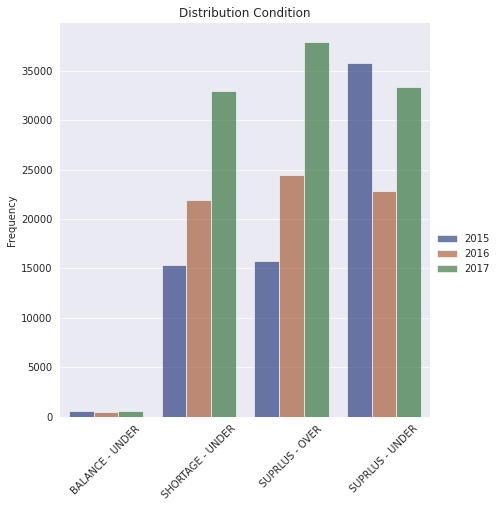

In [114]:
g = sns.catplot(
    data=bjse_status_in_year_visual, kind="bar",
    x="status_name", y="status_count", hue="year",
    ci="sd", palette="dark", alpha=.6, height=6
    )
g.despine(left=True)
g.set_axis_labels("", "Frequency")
g.legend.set_title("")
plt.title("Distribution Condition")
plt.xticks(rotation=45)
plt.show()

In [115]:
# summary distribution status per station in 2017
new2_bjse_2017 = new2_bjse[new2_bjse['year']==2017]
new2_bjse_2017 = new2_bjse_2017.groupby(['station_name']).agg({'cum_flow':'mean','capacity':'mean'}).reset_index()

In [116]:
new2_bjse_2017.loc[(new2_bjse_2017['cum_flow'] == 0) & (new2_bjse_2017['cum_flow'] <= new2_bjse_2017['capacity']), 'condition'] = 'BALANCE-UNDER'
new2_bjse_2017.loc[(new2_bjse_2017['cum_flow'] < 0) & (new2_bjse_2017['cum_flow'] <= new2_bjse_2017['capacity']), 'condition'] = 'SHORTAGE-UNDER'
new2_bjse_2017.loc[(new2_bjse_2017['cum_flow'] > 0) & (new2_bjse_2017['cum_flow'] > new2_bjse_2017['capacity']), 'condition'] = 'SURPLUS-OVER'
new2_bjse_2017.loc[(new2_bjse_2017['cum_flow'] > 0) & (new2_bjse_2017['cum_flow'] <= new2_bjse_2017['capacity']), 'condition'] = 'SURPLUS-UNDER'
new2_bjse_2017.head()

,station_name,cum_flow,capacity,condition
0,1 Ave & E 110 St,28.913043,25,SURPLUS-OVER
1,1 Ave & E 15 St,-316.753731,54,SHORTAGE-UNDER
2,1 Ave & E 18 St,-59.255639,54,SHORTAGE-UNDER
3,1 Ave & E 30 St,-152.394531,29,SHORTAGE-UNDER
4,1 Ave & E 44 St,245.567100,59,SURPLUS-OVER


In [117]:
balance_under = new2_bjse_2017[new2_bjse_2017['condition']=='BALANCE-UNDER'].sort_values(by=['cum_flow'], ascending=False)
shortage_under = new2_bjse_2017[new2_bjse_2017['condition']=='SHORTAGE-UNDER'].sort_values(by=['cum_flow'], ascending=True)
surplus_over = new2_bjse_2017[new2_bjse_2017['condition']=='SURPLUS-OVER'].sort_values(by=['cum_flow'], ascending=False)
surplus_under = new2_bjse_2017[new2_bjse_2017['condition']=='SURPLUS-UNDER'].sort_values(by=['cum_flow'], ascending=False)

In [118]:
print(len(surplus_over))
print(len(shortage_under))

194
150


In [119]:
surplus_over.loc["Total", "cum_flow"] = surplus_over.cum_flow.sum()
surplus_over.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,16997.062713,NaN,NaN


In [120]:
shortage_under.loc["Total", "cum_flow"] = shortage_under.cum_flow.sum()
shortage_under.tail(1)

,station_name,cum_flow,capacity,condition
Total,NaN,-10682.536947,NaN,NaN


It is still possible to distribute from surplus_over to shortage_under

In [121]:
q_surplus_over = surplus_over.quantile([.1, .25, .5, .75], axis = 0)
q2_surplus_over = q_surplus_over.iloc[1,0]
q3_surplus_over = q_surplus_over.iloc[2,0]

In [122]:
def f(row):
    if row['cum_flow'] > q2_surplus_over:
        val = '1'
    elif row['cum_flow'] < q3_surplus_over:
        val = 3
    else:
        val = 2
    return val

surplus_over['priority'] = surplus_over.apply(f, axis=1)

In [123]:
surplus_over.head()

,station_name,cum_flow,capacity,condition,priority
609,W 33 St & 7 Ave,639.438931,68.0,SURPLUS-OVER,1
166,Broadway & W 58 St,300.223485,0.0,SURPLUS-OVER,1
615,W 41 St & 8 Ave,282.431452,71.0,SURPLUS-OVER,1
557,Suffolk St & Stanton St,265.165414,79.0,SURPLUS-OVER,1
453,Market St & Cherry St,251.930502,45.0,SURPLUS-OVER,1


In [124]:
q_shortage_under = shortage_under.quantile([.1, .25, .5, .75], axis = 0)
q2_shortage_under = q_shortage_under.iloc[1,0]
q3_shortage_under = q_shortage_under.iloc[2,0]

In [125]:
def f(row):
    if row['cum_flow'] < q2_shortage_under:
        val = '1'
    elif row['cum_flow'] > q3_shortage_under:
        val = 3
    else:
        val = 2
    return val

shortage_under['priority'] = shortage_under.apply(f, axis=1)

In [126]:
shortage_under.head()

,station_name,cum_flow,capacity,condition,priority
1,1 Ave & E 15 St,-316.753731,54.0,SHORTAGE-UNDER,1
482,Norfolk St & Broome St,-265.178030,31.0,SHORTAGE-UNDER,1
215,Columbia St & Rivington St,-246.739623,29.0,SHORTAGE-UNDER,1
606,W 26 St & 8 Ave,-235.595142,66.0,SHORTAGE-UNDER,1
550,Stanton St & Chrystie St,-233.862069,35.0,SHORTAGE-UNDER,1


###Check the strange value

In [127]:
k = new_bjse.groupby(['station_name', 'date']).last().reset_index()
k.head()

,station_name,date,docktime,in_out,cum_flow
0,1 Ave & E 110 St,2010-01-01,2010-01-01 12:00:00,22,22
1,1 Ave & E 110 St,2017-08-30,2017-08-30 14:10:20,1,23
2,1 Ave & E 110 St,2017-09-02,2017-09-02 20:57:19,1,24
3,1 Ave & E 110 St,2017-09-03,2017-09-03 14:31:23,1,25
4,1 Ave & E 110 St,2017-09-07,2017-09-07 18:21:17,1,26


In [128]:
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)
k[k['station_name']=='1 Ave & E 15 St']

,station_name,date,docktime,in_out,cum_flow
24,1 Ave & E 15 St,2010-01-01,2010-01-01 12:00:00,11,11
25,1 Ave & E 15 St,2015-01-01,2015-01-01 19:37:00,-1,10
26,1 Ave & E 15 St,2015-01-02,2015-01-02 20:38:00,1,11
27,1 Ave & E 15 St,2015-01-03,2015-01-03 17:10:00,1,12
28,1 Ave & E 15 St,2015-01-04,2015-01-04 11:01:00,-1,12
29,1 Ave & E 15 St,2015-01-05,2015-01-05 17:05:00,-1,10
30,1 Ave & E 15 St,2015-01-07,2015-01-07 11:10:00,1,11
31,1 Ave & E 15 St,2015-01-08,2015-01-08 17:46:00,-1,12
32,1 Ave & E 15 St,2015-01-09,2015-01-09 19:16:00,1,14
33,1 Ave & E 15 St,2015-01-10,2015-01-10 12:57:00,-1,13
